In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

In [2]:
rules = pd.read_csv("recommend-output.csv")
#to_lib2max_freq = {to_lib: max(row["ruleFreqSameCommit"]) for to_lib, row in rules.groupby(by="toLib")}
#rules["ruleFreqToLibSameCommit"] = rules["ruleFreqSameCommit"] / rules["toLib"].apply(lambda x: to_lib2max_freq[x])
#rules.insert(4, "confTeyton", np.minimum(rules["ruleFreqSameCommit"], rules["ruleFreqToLibSameCommit"]).fillna(0))
to_lib2cnt = {to_lib: len(rows) for to_lib, rows in rules.groupby(by="toLib")}
from_lib2cnt = {from_lib: len(rows) for from_lib, rows in rules.groupby(by="fromLib")}
rules["confTeyton"] = (rules["ruleCountSameCommit"] / np.maximum(
    rules["toLib"].apply(lambda x: to_lib2cnt[x]),
    rules["fromLib"].apply(lambda x: from_lib2cnt[x])
)).fillna(0)
# to_lib2max_freq = {to_lib: max(row["ruleFreq"]) for to_lib, row in rules.groupby(by="toLib")}
# rules["ruleFreqToLib"] = rules["ruleFreq"] / rules["toLib"].apply(lambda x: to_lib2max_freq[x])
# rules["popularityRegularization"] = rules["ruleFreq"] * rules["concurrenceAdjustment"]
# from_lib2max_count = {from_lib: max(row["possibleCommitCount"]) for from_lib, row in rules.groupby(by="fromLib")}
# rules["commitMessageSupport"] = [x / (from_lib2max_count[from_lib] + 1) for from_lib, x in zip(rules["fromLib"], rules["possibleCommitCount"])]

In [3]:
from_libs = set()
with open("from-lib-confirmed.txt", "r") as f:
    from_libs = set(x.strip() for x in f)
len(from_libs), len(from_libs - set(rules["fromLib"]))

(195, 1)

In [4]:
ground_truth = pd.read_excel("manual/ground-truth.xlsx")
rules_existed = set(zip(rules["fromLib"], rules["toLib"]))
confirmed_rule_set = set(zip(
    ground_truth[ground_truth["isConfirmed"]]["fromLib"], 
    ground_truth[ground_truth["isConfirmed"]]["toLib"]
)) & rules_existed
possible_rule_set = (set(zip(
    ground_truth[ground_truth["ruleCount"] > 0]["fromLib"], 
    ground_truth[ground_truth["ruleCount"] > 0]["toLib"]
)) | confirmed_rule_set) & rules_existed

rules["isPossible"] = [x in possible_rule_set for x in zip(rules["fromLib"], rules["toLib"])]
# rules.insert(2, "isConfirmed", [x in confirmed_rule_set for x in zip(rules["fromLib"], rules["toLib"])])
possible_rules = rules[rules["isPossible"]]
confirmed_rules = rules[rules["isConfirmed"]]
other_rules = rules[~rules["isConfirmed"] & ~rules["isPossible"]]
print("# rules = {}, # confirmed = {}, # possible = {}, # confirmed from libs = {}".format(
    len(rules), len(confirmed_rule_set), len(possible_rule_set), 
    len(set(x[0] for x in confirmed_rule_set))
))

# rules = 243152, # confirmed = 773, # possible = 1446, # confirmed from libs = 190


In [5]:
def evaluate(method, rules, possible_rules, confirmed_rules):
    top_k = 100
    top_rules = [list() for x in range(0, top_k)]
    ndcg_possible_at_k = [list() for x in range(0, top_k)]
    ndcg_confirmed_at_k = [list() for x in range(0, top_k)]
    from_lib_set = set(x for x, y in confirmed_rules)
    reciprocal_ranks_confirmed = {}
    reciprocal_ranks_possible = {}
    for from_lib, candidates in rules.groupby(by="fromLib"):
        if from_lib not in from_lib_set:
            continue
        this_rules = [(from_lib, to_lib) for to_lib in candidates["toLib"]]
        this_possible_rules = [(from_lib, to_lib) for from_lib, to_lib in this_rules if (from_lib, to_lib) in possible_rules]
        this_confirmed_rules = [(from_lib, to_lib) for from_lib, to_lib in this_rules if (from_lib, to_lib) in confirmed_rules]
        last_k, last_ndcg = 0, 0
        for k, (from_lib, to_lib) in enumerate(this_rules):
            if k >= top_k:
                continue
            last_k = k
            top_rules[k].append((from_lib, to_lib))
            if (from_lib, to_lib) in possible_rules and from_lib not in reciprocal_ranks_possible:
                reciprocal_ranks_possible[from_lib] = 1 / (k + 1)
            if (from_lib, to_lib) in confirmed_rules and from_lib not in reciprocal_ranks_confirmed:
                reciprocal_ranks_confirmed[from_lib] = 1 / (k + 1)
            dcg_p = sum(int((from_lib, to_lib) in possible_rules) / np.log2(i+2) for i, (from_lib, to_lib) in enumerate(this_rules[0:k+1]))
            idcg_p = sum(1 / np.log2(i+2) for i in range(0, min(k + 1, len(this_possible_rules))))
            if idcg_p == 0:
                ndcg_possible_at_k[k].append(0)
            else:
                ndcg_possible_at_k[k].append(dcg_p / idcg_p)
            dcg_c = sum(int((from_lib, to_lib) in confirmed_rules) / np.log2(i+2) for i, (from_lib, to_lib) in enumerate(this_rules[0:k+1]))
            idcg_c = sum(1 / np.log2(i+2) for i in range(0, min(k + 1, len(this_confirmed_rules))))
            if idcg_c == 0:
                ndcg_confirmed_at_k[k].append(0)
                last_ndcg = 0
            else:
                ndcg_confirmed_at_k[k].append(dcg_c / idcg_c)
                last_ndcg = dcg_c / idcg_c
        for k in range(last_k + 1, top_k):
            ndcg_confirmed_at_k[k].append(last_ndcg)
        if from_lib not in reciprocal_ranks_possible:
            reciprocal_ranks_possible[from_lib] = 0
        if from_lib not in reciprocal_ranks_confirmed:
            reciprocal_ranks_confirmed[from_lib] = 0
    for k in range(1, top_k):
        top_rules[k] += top_rules[k - 1] 
    result = {
        "Name": method,
        "FromLibCount": len(from_lib_set & set(rules["fromLib"])),
        "MRR-C": np.mean(list(reciprocal_ranks_confirmed.values())),
        "MRR-P": np.mean(list(reciprocal_ranks_possible.values())),
        "Precision-C@k": [],
        "Precision-P@k": [],
        "Recall-C@k": [],
        "Recall-P@k": [],
        "NDCG-C@k": [],
        "NDCG-P@k": [],
    }
    for k in range(0, top_k):
        precision = len([x for x in top_rules[k] if x in confirmed_rules]) / len(top_rules[k])
        recall = len([x for x in top_rules[k] if x in confirmed_rules]) / len(confirmed_rules)
        precision_possible = len([x for x in top_rules[k] if x in possible_rules]) / len(top_rules[k])
        recall_possible = len([x for x in top_rules[k] if x in possible_rules]) / len(possible_rules)
        result["Precision-C@k"].append(precision)
        result["Precision-P@k"].append(precision_possible)
        result["Recall-C@k"].append(recall)
        result["Recall-P@k"].append(recall_possible)
        result["NDCG-C@k"].append(np.mean(ndcg_confirmed_at_k[k]))
        result["NDCG-P@k"].append(np.mean(ndcg_possible_at_k[k]))
    return result
def print_evaluation_result(result):
    print("Result of {} on {} Library Queries:".format(result["Name"], result["FromLibCount"]))
    print("MRR-C/P = {}/{}".format(result["MRR-C"], result["MRR-P"]))
    for k in range(0, len(result["Precision-C@k"])):
        if k + 1 > 10 and (k + 1) % 10 != 0:
            continue
        print("Top {:3}: Precision = {:0.4f}, Recall = {:0.4f}, NDCG = {:0.4f}"
              .format(k + 1, result["Precision-C@k"][k], result["Recall-C@k"][k], result["NDCG-C@k"][k]))
def print_one_line_evaluation_result(result):
    print("{:30}: Precision@1 = {:0.4f}, MRR = {:0.4f}, Recall@5 = {:0.4f}, Recall@10 = {:0.4f}, "
         "Recall@20 = {:0.4f}, NDCG@10 = {:0.4f}".format(
             result["Name"],
             result["Precision-C@k"][0],
             result["MRR-C"],
             result["Recall-C@k"][4],
             result["Recall-C@k"][9],
             result["Recall-C@k"][19],
             result["NDCG-C@k"][9]
         ))

In [6]:
def our_method(rules):
    rules["confidence"] = (
        # np.minimum(0.15, rules["confTeyton"])
        # np.log2(rules["confTeyton"] + 1)
        # rules["confTeyton"]
        rules["ruleFreqSameCommit"]
        # * rules["ruleFreq"]
        # * rules["ruleCount"] / rules["concurrence"]
        # * rules["concurrenceAdjustment"]
        # * np.minimum(rules["ruleFreq"], rules["ruleFreqToLib"])
        * np.maximum(0.1, rules["apiSupport"])
        # * rules["positionSupport"] 
        * rules["commitDistance"]
        * np.log2(rules["possibleCommitCount"] + 1)
        # * np.maximum(0.2, rules["commitMessageSupport"])
        # * np.minimum(rules["similarity"], 0.1)
    )
    return rules.sort_values(by=["fromLib", "confidence"], ascending=[True, False])
result = evaluate("Our Method", our_method(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)
our_method(rules).to_csv("recommend-output.csv", index=False)

Result of Our Method on 190 Library Queries:
MRR-C/P = 0.8565813287461487/0.8565813287461487
Top   1: Precision = 0.7947, Recall = 0.1953, NDCG = 0.7947
Top   2: Precision = 0.6614, Recall = 0.3234, NDCG = 0.7836
Top   3: Precision = 0.5583, Recall = 0.4088, NDCG = 0.7669
Top   4: Precision = 0.4907, Recall = 0.4787, NDCG = 0.7640
Top   5: Precision = 0.4374, Recall = 0.5330, NDCG = 0.7611
Top   6: Precision = 0.3912, Recall = 0.5718, NDCG = 0.7580
Top   7: Precision = 0.3584, Recall = 0.6106, NDCG = 0.7594
Top   8: Precision = 0.3351, Recall = 0.6520, NDCG = 0.7639
Top   9: Precision = 0.3146, Recall = 0.6882, NDCG = 0.7690
Top  10: Precision = 0.2918, Recall = 0.7089, NDCG = 0.7702
Top  20: Precision = 0.1849, Recall = 0.8939, NDCG = 0.8123
Top  30: Precision = 0.1288, Recall = 0.9276, NDCG = 0.8220
Top  40: Precision = 0.0986, Recall = 0.9405, NDCG = 0.8253
Top  50: Precision = 0.0803, Recall = 0.9483, NDCG = 0.8268
Top  60: Precision = 0.0678, Recall = 0.9547, NDCG = 0.8285
Top  70

In [7]:
def teyton_2013(rules):
    return rules.sample(frac=1).sort_values(by=["fromLib", "confTeyton"], ascending=[True, False])
result = evaluate("Teyton et al. 2013", teyton_2013(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)

Result of Teyton et al. 2013 on 190 Library Queries:
MRR-C/P = 0.7177737092794126/0.7256631558654647
Top   1: Precision = 0.6421, Recall = 0.1578, NDCG = 0.6421
Top   2: Precision = 0.5000, Recall = 0.2445, NDCG = 0.6009
Top   3: Precision = 0.4223, Recall = 0.3092, NDCG = 0.5874
Top   4: Precision = 0.3753, Recall = 0.3661, NDCG = 0.5831
Top   5: Precision = 0.3386, Recall = 0.4127, NDCG = 0.5800
Top   6: Precision = 0.3142, Recall = 0.4592, NDCG = 0.5837
Top   7: Precision = 0.2908, Recall = 0.4955, NDCG = 0.5852
Top   8: Precision = 0.2753, Recall = 0.5356, NDCG = 0.5936
Top   9: Precision = 0.2578, Recall = 0.5640, NDCG = 0.5990
Top  10: Precision = 0.2439, Recall = 0.5925, NDCG = 0.6048
Top  20: Precision = 0.1517, Recall = 0.7335, NDCG = 0.6376
Top  30: Precision = 0.1103, Recall = 0.7943, NDCG = 0.6554
Top  40: Precision = 0.0870, Recall = 0.8292, NDCG = 0.6644
Top  50: Precision = 0.0734, Recall = 0.8668, NDCG = 0.6742
Top  60: Precision = 0.0626, Recall = 0.8810, NDCG = 0.6777

In [8]:
def teyton_20132(rules):
    return rules[rules["confTeyton"]>=0.002].sample(frac=1).sort_values(by=["fromLib", "confTeyton"], ascending=[True, False])
result = evaluate("Teyton et al. 2013", teyton_20132(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)

Result of Teyton et al. 2013 on 185 Library Queries:
MRR-C/P = 0.728420312957656/0.7336841482214912
Top   1: Precision = 0.6703, Recall = 0.1604, NDCG = 0.6703
Top   2: Precision = 0.5125, Recall = 0.2393, NDCG = 0.6358
Top   3: Precision = 0.4592, Recall = 0.3131, NDCG = 0.6480
Top   4: Precision = 0.4073, Recall = 0.3609, NDCG = 0.6476
Top   5: Precision = 0.3726, Recall = 0.4049, NDCG = 0.6520
Top   6: Precision = 0.3509, Recall = 0.4476, NDCG = 0.6620
Top   7: Precision = 0.3301, Recall = 0.4799, NDCG = 0.6698
Top   8: Precision = 0.3171, Recall = 0.5149, NDCG = 0.6805
Top   9: Precision = 0.3033, Recall = 0.5395, NDCG = 0.6871
Top  10: Precision = 0.2897, Recall = 0.5576, NDCG = 0.6909
Top  20: Precision = 0.2123, Recall = 0.6404, NDCG = 0.7160
Top  30: Precision = 0.1822, Recall = 0.6611, NDCG = 0.7228
Top  40: Precision = 0.1698, Recall = 0.6701, NDCG = 0.7265
Top  50: Precision = 0.1639, Recall = 0.6727, NDCG = 0.7274
Top  60: Precision = 0.1602, Recall = 0.6727, NDCG = 0.7274


In [9]:
def teyton_20133(rules):
    return rules[rules["confTeyton"]>=0.015].sample(frac=1).sort_values(by=["fromLib", "confTeyton"], ascending=[True, False])
result = evaluate("Teyton et al. 2013", teyton_20133(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)

Result of Teyton et al. 2013 on 95 Library Queries:
MRR-C/P = 0.8862573099415206/0.8862573099415206
Top   1: Precision = 0.8737, Recall = 0.1074, NDCG = 0.8737
Top   2: Precision = 0.7820, Recall = 0.1345, NDCG = 0.8722
Top   3: Precision = 0.7405, Recall = 0.1514, NDCG = 0.8771
Top   4: Precision = 0.7209, Recall = 0.1604, NDCG = 0.8826
Top   5: Precision = 0.7111, Recall = 0.1656, NDCG = 0.8832
Top   6: Precision = 0.7043, Recall = 0.1695, NDCG = 0.8845
Top   7: Precision = 0.7000, Recall = 0.1721, NDCG = 0.8857
Top   8: Precision = 0.6995, Recall = 0.1746, NDCG = 0.8877
Top   9: Precision = 0.6974, Recall = 0.1759, NDCG = 0.8909
Top  10: Precision = 0.6904, Recall = 0.1759, NDCG = 0.8909
Top  20: Precision = 0.6766, Recall = 0.1759, NDCG = 0.8909
Top  30: Precision = 0.6766, Recall = 0.1759, NDCG = 0.8909
Top  40: Precision = 0.6766, Recall = 0.1759, NDCG = 0.8909
Top  50: Precision = 0.6766, Recall = 0.1759, NDCG = 0.8909
Top  60: Precision = 0.6766, Recall = 0.1759, NDCG = 0.8909


/home/heh/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/heh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
def alrubaye_2019(rules):
    return rules[
        (rules["methodChangeCount"] > 0) & (rules["ruleFreqSameCommit"] >= 0.6)
    ].sort_values(by=["fromLib", "ruleFreqSameCommit"], ascending=[True, False])
result = evaluate("Alrubaye et al. 2019", alrubaye_2019(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)

Result of Alrubaye et al. 2019 on 34 Library Queries:
MRR-C/P = 0.9411764705882353/0.9411764705882353
Top   1: Precision = 0.9412, Recall = 0.0414, NDCG = 0.9412
Top   2: Precision = 0.9250, Recall = 0.0479, NDCG = 0.9412
Top   3: Precision = 0.9268, Recall = 0.0492, NDCG = 0.9412
Top   4: Precision = 0.9268, Recall = 0.0492, NDCG = 0.9412
Top   5: Precision = 0.9268, Recall = 0.0492, NDCG = 0.9412
Top   6: Precision = 0.9268, Recall = 0.0492, NDCG = 0.9412
Top   7: Precision = 0.9268, Recall = 0.0492, NDCG = 0.9412
Top   8: Precision = 0.9268, Recall = 0.0492, NDCG = 0.9412
Top   9: Precision = 0.9268, Recall = 0.0492, NDCG = 0.9412
Top  10: Precision = 0.9268, Recall = 0.0492, NDCG = 0.9412
Top  20: Precision = 0.9268, Recall = 0.0492, NDCG = 0.9412
Top  30: Precision = 0.9268, Recall = 0.0492, NDCG = 0.9412
Top  40: Precision = 0.9268, Recall = 0.0492, NDCG = 0.9412
Top  50: Precision = 0.9268, Recall = 0.0492, NDCG = 0.9412
Top  60: Precision = 0.9268, Recall = 0.0492, NDCG = 0.941

In [11]:
def regression(rules):
    feat_names = ["confTeyton", "apiSupportMin", "commitDistance", "possibleCommitCount"]
    rules["apiSupportMin"] = rules["apiSupport"].apply(lambda x: max(0.1, x))
    feat_series = {name: np.log2(rules[name] + 1) for name in feat_names}
    X = []
    for i in range(0, len(rules)):
        X.append([feat_series[name].iloc[i] for name in feat_names])      
    y = list(map(
        lambda x: int(x[0]) + int(x[1]),
        zip(rules["isConfirmed"], rules["isPossible"])
    ))
    sample_weight = list(map(
        lambda x: int(x[0]) * 5 + int(x[1]) * 1 + 0.08,
        zip(rules["isConfirmed"], rules["isPossible"])
    ))
    reg = linear_model.TweedieRegressor(power=1, verbose=1)
    reg.fit(X, y, sample_weight)
    for idx, coef in enumerate(reg.coef_):
        print("Coef {}: {}".format(feat_names[idx], coef))
    rules["confidence"] = reg.predict(X)
    return rules.sort_values(by=["fromLib", "confidence"], ascending=[True, False])
result = evaluate("Generalized Linear Model", regression(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)

Coef confTeyton: 0.0020397890837172837
Coef apiSupportMin: 0.01768948475118095
Coef commitDistance: 0.1411219074734114
Coef possibleCommitCount: 0.3026174543921507
Result of Generalized Linear Model on 190 Library Queries:
MRR-C/P = 0.8104735609576461/0.8105571031464515
Top   1: Precision = 0.7368, Recall = 0.1811, NDCG = 0.7368
Top   2: Precision = 0.6190, Recall = 0.3027, NDCG = 0.7270
Top   3: Precision = 0.5106, Recall = 0.3739, NDCG = 0.7023
Top   4: Precision = 0.4403, Recall = 0.4295, NDCG = 0.6904
Top   5: Precision = 0.3992, Recall = 0.4864, NDCG = 0.6949
Top   6: Precision = 0.3637, Recall = 0.5317, NDCG = 0.6965
Top   7: Precision = 0.3326, Recall = 0.5666, NDCG = 0.6968
Top   8: Precision = 0.3092, Recall = 0.6016, NDCG = 0.7030
Top   9: Precision = 0.2850, Recall = 0.6235, NDCG = 0.7035
Top  10: Precision = 0.2678, Recall = 0.6507, NDCG = 0.7082
Top  20: Precision = 0.1659, Recall = 0.8021, NDCG = 0.7436
Top  30: Precision = 0.1202, Recall = 0.8655, NDCG = 0.7603
Top  40: 

In [12]:
def rule_freq(rules):
    return rules.sample(frac=1).sort_values(by=["fromLib", "ruleFreq"], ascending=[True, False])
def rule_freq_same_commit(rules):
    return rules.sample(frac=1).sort_values(by=["fromLib", "ruleFreqSameCommit"], ascending=[True, False])
def rule_freq_to_lib_same_commit(rules):
    return rules.sample(frac=1).sort_values(by=["fromLib", "ruleFreqToLibSameCommit"], ascending=[True, False])
def method(rules, a, b, c, d):
    rules["confidence"] = (
        rules["ruleFreqSameCommit"] ** a
        * np.maximum(0.1, rules["apiSupport"]) ** b
        * rules["commitDistance"] ** c
        * np.log2(rules["possibleCommitCount"] + 1) ** d
    )
    return rules.sample(frac=1).sort_values(by=["fromLib", "confidence"], ascending=[True, False])
def parallel_worker(name, func, params):
    return evaluate(name, func(rules, *params), possible_rule_set, confirmed_rule_set)
methods = [
    ("RuleFreq", rule_freq, ()),
    ("RuleFreqSameCommit", rule_freq_same_commit, ()),
    ("Teyton et al. 2013", teyton_2013, ()),
    ("Alrubaye et al. 2019", alrubaye_2019, ()),
    # ("APISupport", method, (0, 1, 0, 0)), 
    # ("CommitDistance", method, (0, 0, 1, 0)), 
    ("Message", method, (0, 0, 0, 1)),
    # ("ConfTeyton * APISupport", method, (1, 1, 0, 0)),
    # ("ConfTeyton * CommitDistance", method, (1, 1, 1, 0)),
    ("RFSC * Message", method, (1, 0, 0, 1)),
    ("RFSC * Message * Distance", method, (1, 1, 0, 1)),
    ("RFSC * Message * APISupport", method, (1, 0, 1, 1)),
    ("Our Method", our_method, ())
]
pool = multiprocessing.Pool(12)
results = pool.starmap(parallel_worker, methods)
pool.close()
pool.join()
for result in results:
    print_one_line_evaluation_result(result)
# print_one_line_evaluation_result(parallel_worker("Generalized Linear Model", regression, ()))

/home/heh/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/heh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


RuleFreq                      : Precision@1 = 0.4421, MRR = 0.5275, Recall@5 = 0.2354, Recall@10 = 0.3066, Recall@20 = 0.4204, NDCG@10 = 0.3669
RuleFreqSameCommit            : Precision@1 = 0.6632, MRR = 0.7348, Recall@5 = 0.4127, Recall@10 = 0.5796, Recall@20 = 0.7193, NDCG@10 = 0.6073
Teyton et al. 2013            : Precision@1 = 0.6632, MRR = 0.7311, Recall@5 = 0.4101, Recall@10 = 0.5821, Recall@20 = 0.7193, NDCG@10 = 0.6056
Alrubaye et al. 2019          : Precision@1 = 0.9412, MRR = 0.9412, Recall@5 = 0.0492, Recall@10 = 0.0492, Recall@20 = 0.0492, NDCG@10 = 0.9412
Message                       : Precision@1 = 0.6737, MRR = 0.7587, Recall@5 = 0.4476, Recall@10 = 0.6248, Recall@20 = 0.7620, NDCG@10 = 0.6619
RFSC * Message                : Precision@1 = 0.7579, MRR = 0.8277, Recall@5 = 0.5084, Recall@10 = 0.6960, Recall@20 = 0.8564, NDCG@10 = 0.7436
RFSC * Message * Distance     : Precision@1 = 0.7737, MRR = 0.8409, Recall@5 = 0.5265, Recall@10 = 0.7089, Recall@20 = 0.8629, NDCG@10 =

In [13]:
def teyton_20132(rules):
    return rules[rules["confTeyton"]>=0.002].sample(frac=1).sort_values(by=["fromLib", "confTeyton"], ascending=[True, False])
result = evaluate("Teyton et al. 2013", teyton_20132(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)

Result of Teyton et al. 2013 on 185 Library Queries:
MRR-C/P = 0.7331471789925629/0.7366220824674662
Top   1: Precision = 0.6757, Recall = 0.1617, NDCG = 0.6757
Top   2: Precision = 0.5152, Recall = 0.2406, NDCG = 0.6363
Top   3: Precision = 0.4497, Recall = 0.3066, NDCG = 0.6404
Top   4: Precision = 0.4102, Recall = 0.3635, NDCG = 0.6485
Top   5: Precision = 0.3667, Recall = 0.3984, NDCG = 0.6456
Top   6: Precision = 0.3479, Recall = 0.4437, NDCG = 0.6585
Top   7: Precision = 0.3256, Recall = 0.4735, NDCG = 0.6646
Top   8: Precision = 0.3108, Recall = 0.5045, NDCG = 0.6719
Top   9: Precision = 0.2975, Recall = 0.5291, NDCG = 0.6792
Top  10: Precision = 0.2836, Recall = 0.5459, NDCG = 0.6826
Top  20: Precision = 0.2105, Recall = 0.6352, NDCG = 0.7116
Top  30: Precision = 0.1815, Recall = 0.6585, NDCG = 0.7194
Top  40: Precision = 0.1698, Recall = 0.6701, NDCG = 0.7238
Top  50: Precision = 0.1639, Recall = 0.6727, NDCG = 0.7245
Top  60: Precision = 0.1606, Recall = 0.6740, NDCG = 0.7251

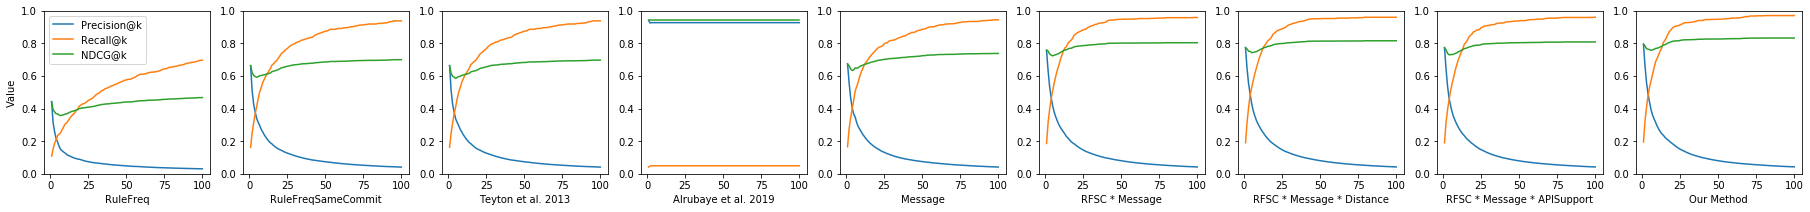

In [14]:
fig, axes = plt.subplots(1, len(methods), figsize=(3.5 * len(methods), 3))
for i, result in enumerate(results):
    x = list(range(1, len(result["Precision-C@k"]) + 1))
    axes[i].plot(x, result["Precision-C@k"], label="Precision@k")
    axes[i].plot(x, result["Recall-C@k"], label="Recall@k")
    axes[i].plot(x, result["NDCG-C@k"], label="NDCG@k")
    axes[i].set_xlabel(result["Name"])
    axes[i].set_ylim([0, 1])
    if i == 0:
        axes[i].set_ylabel("Value")
        axes[i].legend()
fig.show()
fig.savefig("pic/metric-trend.pdf", bbox_inches="tight")

In [15]:
vals = [0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
params = []
for loc in range(0, 4):
    for i in vals:
        param = [1, 1, 1, 1]
        param[loc] = i
        params.append((str(param), method, param))
pool = multiprocessing.Pool(12)
results = pool.starmap(parallel_worker, params)
pool.close()
for result in results:
    print_one_line_evaluation_result(result)

[0.2, 1, 1, 1]                : Precision@1 = 0.7632, MRR = 0.8368, Recall@5 = 0.5188, Recall@10 = 0.6882, Recall@20 = 0.8305, NDCG@10 = 0.7450
[0.4, 1, 1, 1]                : Precision@1 = 0.7842, MRR = 0.8508, Recall@5 = 0.5304, Recall@10 = 0.6921, Recall@20 = 0.8448, NDCG@10 = 0.7580
[0.6, 1, 1, 1]                : Precision@1 = 0.7895, MRR = 0.8526, Recall@5 = 0.5343, Recall@10 = 0.7025, Recall@20 = 0.8590, NDCG@10 = 0.7637
[0.8, 1, 1, 1]                : Precision@1 = 0.7842, MRR = 0.8491, Recall@5 = 0.5369, Recall@10 = 0.7089, Recall@20 = 0.8706, NDCG@10 = 0.7672
[1.0, 1, 1, 1]                : Precision@1 = 0.7842, MRR = 0.8486, Recall@5 = 0.5369, Recall@10 = 0.7115, Recall@20 = 0.8810, NDCG@10 = 0.7678
[1.5, 1, 1, 1]                : Precision@1 = 0.7842, MRR = 0.8469, Recall@5 = 0.5395, Recall@10 = 0.7128, Recall@20 = 0.8797, NDCG@10 = 0.7672
[2.0, 1, 1, 1]                : Precision@1 = 0.7789, MRR = 0.8438, Recall@5 = 0.5369, Recall@10 = 0.7128, Recall@20 = 0.8784, NDCG@10 =